In [1]:
from ema_workbench import load_results
from HHCART import HHCartD
from src.config.paths import HAMARAT_DATA_DIR

In [2]:
# === Load results from .tar.gz archive ===
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs.tar.gz")

In [3]:
# === Define binary outcome using the final timestep of renewable share ===
fraction_renewables = outcomes["fraction_renewables"]
final_renewable_share = fraction_renewables[:, -1]  # Last year (e.g., 2100)

# Define binary classification: 1 = undesirable (< 60%), 0 = desirable (>= 60%)
label = (final_renewable_share < 0.45).astype(int)
experiments["label"] = label

# === Correct column name typo ===
if "SWTICH_preference_carbon_curve" in experiments.columns:
    experiments = experiments.rename(columns={"SWTICH_preference_carbon_curve": "SWITCH_preference_carbon_curve"})
    print("✅ Renamed column: 'SWTICH_preference_carbon_curve' → 'SWITCH_preference_carbon_curve'")

# === Drop rows where all SWITCH variables are 0 ===
switch_cols = [col for col in experiments.columns if col.startswith("SWITCH")]
print(f"🔍 Found {len(switch_cols)} SWITCH columns.")

initial_count = len(experiments)
mask = ~(experiments[switch_cols] == 0).all(axis=1)
experiments = experiments[mask].copy()
dropped_count = initial_count - len(experiments)
print(f"🧹 Dropped {dropped_count} experiments where all SWITCH variables are 0")
print(f"✅ Remaining experiments: {len(experiments)}")

# === Prepare features for PRIM ===
columns_to_drop = ["label", "model", "policy", "scenario", "year"]
columns_to_drop = [col for col in columns_to_drop if col in experiments.columns]
X_df = experiments.drop(columns=columns_to_drop)
y_array = experiments["label"].values

# Optional: Convert SWITCH-related columns to categorical (disabled unless needed)
# categorical_cols = [col for col in X_df.columns if col.lower().startswith("switch")]
# X_df[categorical_cols] = X_df[categorical_cols].astype("category")

# === Drop all SWITCH-related columns (Because oblique DT algorithms can't handle categorical variables) ===
switch_cols = [col for col in X_df.columns if col.startswith("SWITCH")]
X_df = X_df.drop(columns=switch_cols)
print(f"🧹 Dropped {len(switch_cols)} SWITCH columns from PRIM input: {switch_cols}")

# === Print label distribution ===
label_counts = experiments["label"].value_counts().rename(index={0: "Desirable (0)", 1: "Undesirable (1)"})
print("\n📊 Label distribution after filtering:")
print(label_counts)

✅ Renamed column: 'SWTICH_preference_carbon_curve' → 'SWITCH_preference_carbon_curve'
🔍 Found 12 SWITCH columns.
🧹 Dropped 0 experiments where all SWITCH variables are 0
✅ Remaining experiments: 10000
🧹 Dropped 12 SWITCH columns from PRIM input: ['SWITCH_Market_price_determination', 'SWITCH_TGC_obligation_curve', 'SWITCH_carbon_cap', 'SWITCH_carbon_price_determination', 'SWITCH_economic_growth', 'SWITCH_electrification_rate', 'SWITCH_interconnection_capacity_expansion', 'SWITCH_lookup_curve_TGC', 'SWITCH_low_reserve_margin_price_markup', 'SWITCH_physical_limits', 'SWITCH_storage_for_intermittent_supply', 'SWITCH_preference_carbon_curve']

📊 Label distribution after filtering:
label
Undesirable (1)    6431
Desirable (0)      3569
Name: count, dtype: int64


In [5]:
# Instantiate HHCART with mutual information as feature selector
hh = HHCartD(X_df, y_array, max_depth=3, feature_selector="mutual_info")

In [6]:
# Build trees with top-K feature subsets (e.g., top 2, 3, 4, 5 features)
hh.build_tree(k_range=[2 ,3, 4]) 
# hh.build_tree(k_range=[2, 3]) 

🔍 Computing feature scores using selector...

🌲 Building tree with top-2 features:
   ➤ Selected features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban']


Building tree layer by layer: 100%|██████████| 3/3 [00:24<00:00,  8.19s/depth]


✅ Done: Built tree up to depth 3
   Accuracy: 0.689, Coverage: 0.894, Density: 0.703

🌲 Building tree with top-3 features:
   ➤ Selected features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban', 'economic_lifetime_wind']


Building tree layer by layer: 100%|██████████| 3/3 [00:36<00:00, 12.03s/depth]

✅ Done: Built tree up to depth 3
   Accuracy: 0.686, Coverage: 0.925, Density: 0.691


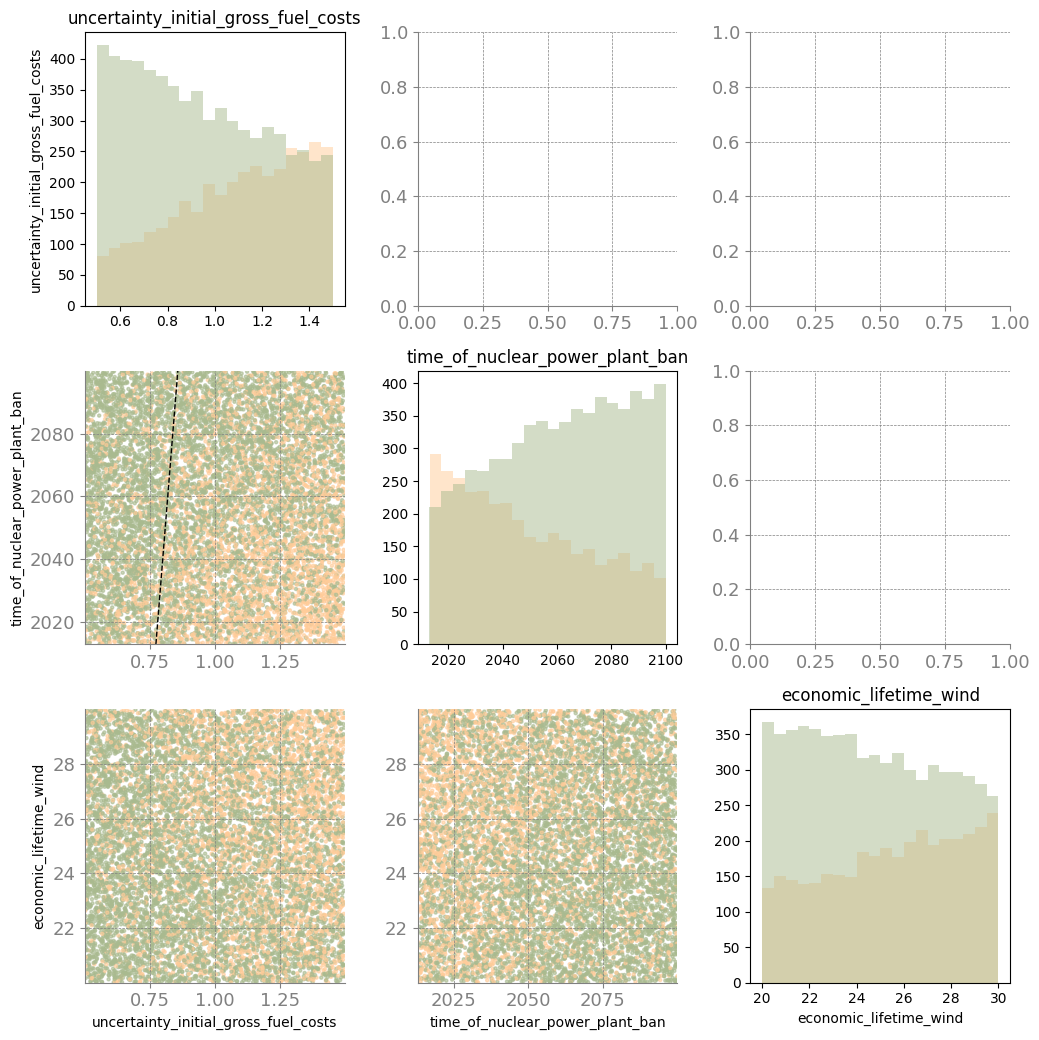

In [7]:
# Visualise pairwise splits for (k=3, depth=3)
hh.plot_pairwise_splits(k=3, depth=3)

In [15]:
# Save the metrics DataFrame to CSV in the current folder
hh.metrics_df.to_csv("metrics_hhcart.csv", index=False)
print("✅ Saved metrics to 'metrics_hhcart.csv'")

✅ Saved metrics to 'metrics_hhcart.csv'


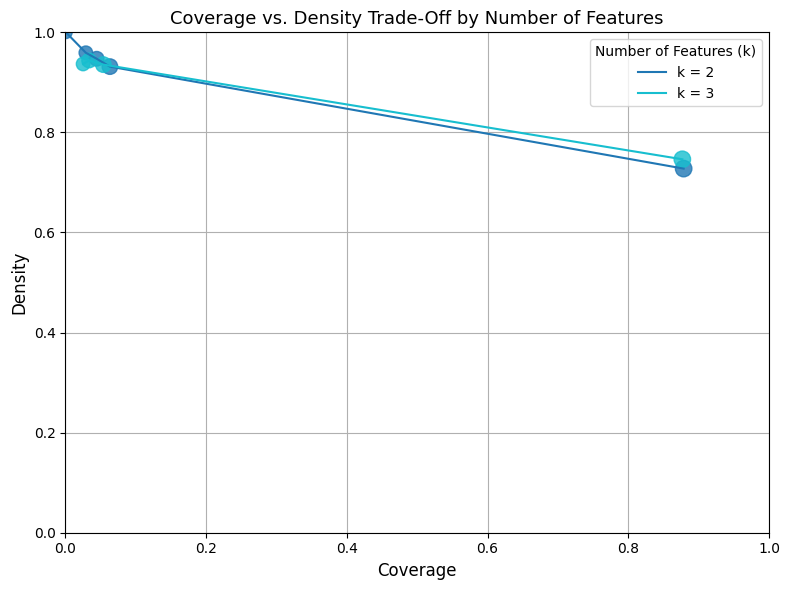

In [16]:
hh.plot_coverage_density_tradeoff()

In [7]:
# Select tree at depth 3 using top 6 features
hh.select(depth=3, k=3)

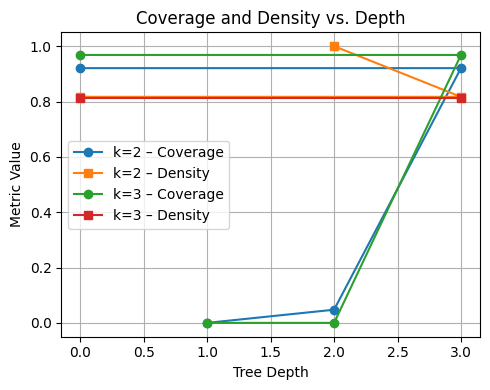

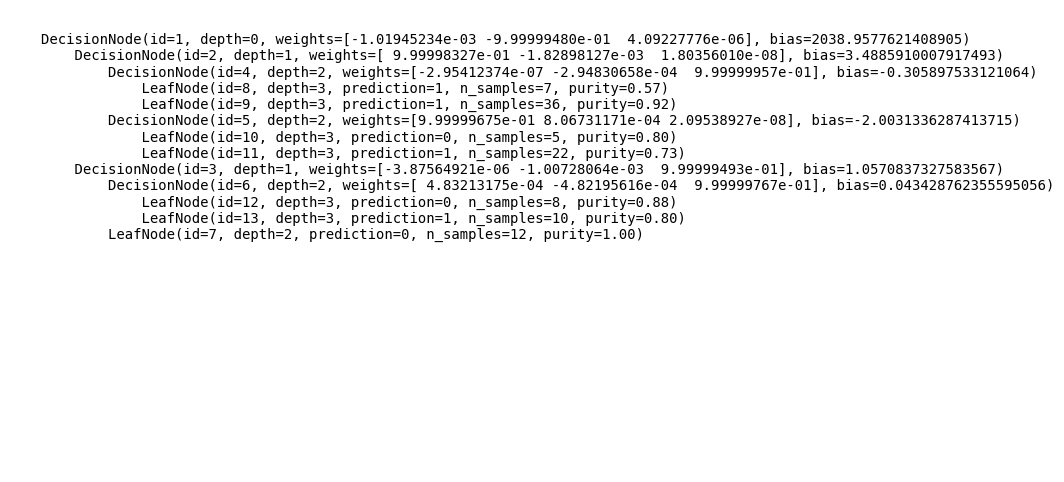

AttributeError: 'DecisionTree' object has no attribute 'print_structure'

In [8]:
# Visualise and inspect
hh.plot_tradeoff()
hh.plot_tree()
hh.inspect()
hh.show_pairs_scatter()